# WESAD Stress Detection Model

Here's the steps of training a stress detection model using the WESAD dataset:
1. Load & Explore
2. Extract
3. Train
4. Evaluate

In [1]:
import sys
sys.path.append('../src')

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path

# Import WESAD helper functions
from wesad.load_wesad import load_subject_data, extract_labels, extract_chest_signals
from wesad.features_eda import extract_eda_features
from wesad.features_hrv import extract_hrv_features
from wesad.normalization import normalize_subjects


## 1. Load & Explore WESAD Data

In [2]:
def load_subject(subject_dir):
    """
    Load one WESAD subject folder (e.g., .../WESAD/S2/) and return a dict:
      signals["EDA"], ["BVP"], ["ACC"], ["TEMP"], ["HR"] -> {"time": np.ndarray, "data": np.ndarray, "fs": float, "start": float}
      signals["IBI"] -> pd.DataFrame with columns ["t_rel", "ibi", "time"]
      signals["tags"] -> pd.DataFrame with column ["time"]
      signals["_paths"] -> {"subject_dir": Path, "e4_dir": Path}
    """
    subject_dir = Path(subject_dir).expanduser().resolve()
    if not subject_dir.exists():
        raise FileNotFoundError(f"Subject directory not found: {subject_dir}")

    # Find *_E4_data (case-insensitive)
    e4_candidates = [p for p in subject_dir.iterdir()
                     if p.is_dir() and p.name.lower().endswith("_e4_data")]
    if not e4_candidates:
        contents = [p.name for p in subject_dir.iterdir()]
        raise FileNotFoundError(
            f"No '*_E4_data' folder found inside: {subject_dir}\n"
            f"Contents: {contents}"
        )
    if len(e4_candidates) > 1:
        e4_candidates.sort()
    e4_dir = e4_candidates[0]

    def _load_standard_signal(csv_name, expect_cols=None):
        p = e4_dir / csv_name
        if not p.exists():
            raise FileNotFoundError(f"Missing file: {p}")

        raw = pd.read_csv(p, header=None)
        if raw.shape[0] < 3:
            raise ValueError(f"File too short: {p} (rows={raw.shape[0]})")

        start = float(raw.iloc[0, 0])
        fs = float(raw.iloc[1, 0])
        data = raw.iloc[2:].to_numpy(dtype=float)

        if expect_cols is not None and data.shape[1] != expect_cols:
            raise ValueError(f"{p.name}: expected {expect_cols} columns, got {data.shape[1]}")

        t = start + np.arange(data.shape[0], dtype=float) / fs
        return {"time": t, "data": data, "fs": fs, "start": start}

    signals = {
        "_paths": {"subject_dir": subject_dir, "e4_dir": e4_dir}
    }

    # Standard sampled signals
    signals["EDA"]  = _load_standard_signal("EDA.csv",  expect_cols=1)
    signals["BVP"]  = _load_standard_signal("BVP.csv",  expect_cols=1)
    signals["TEMP"] = _load_standard_signal("TEMP.csv", expect_cols=1)
    signals["HR"]   = _load_standard_signal("HR.csv",   expect_cols=1)
    signals["ACC"]  = _load_standard_signal("ACC.csv",  expect_cols=3)

    # IBI: first row start unix time; remaining rows are [t_rel, ibi]
    ibi_path = e4_dir / "IBI.csv"
    if not ibi_path.exists():
        raise FileNotFoundError(f"Missing file: {ibi_path}")

    ibi_raw = pd.read_csv(ibi_path, header=None)
    if ibi_raw.shape[0] < 2 or ibi_raw.shape[1] < 2:
        raise ValueError(f"Unexpected IBI.csv shape: {ibi_raw.shape} at {ibi_path}")

    ibi_start = float(ibi_raw.iloc[0, 0])
    ibi = ibi_raw.iloc[1:, :2].copy()
    ibi.columns = ["t_rel", "ibi"]
    ibi["t_rel"] = pd.to_numeric(ibi["t_rel"], errors="coerce")
    ibi["ibi"] = pd.to_numeric(ibi["ibi"], errors="coerce")
    ibi = ibi.dropna().reset_index(drop=True)
    ibi["time"] = ibi_start + ibi["t_rel"].to_numpy(dtype=float)
    signals["IBI"] = ibi

    # tags: each row is an absolute unix timestamp
    tags_path = e4_dir / "tags.csv"
    if not tags_path.exists():
        raise FileNotFoundError(f"Missing file: {tags_path}")

    tags = pd.read_csv(tags_path, header=None, names=["time"])
    tags["time"] = pd.to_numeric(tags["time"], errors="coerce")
    tags = tags.dropna().reset_index(drop=True)
    signals["tags"] = tags

    return signals

WESAD_ROOT = Path("/Users/maggiebowen/Documents/GitHub/doomstopping/data/raw")

# test calls
signals = load_subject(WESAD_ROOT / "S2")
print(signals.keys())
print("EDA data shape:", signals["EDA"]["data"].shape)
print("IBI head:\n", signals["IBI"].head())

dict_keys(['_paths', 'EDA', 'BVP', 'TEMP', 'HR', 'ACC', 'IBI', 'tags'])
EDA data shape: (31494, 1)
IBI head:
        t_rel       ibi          time
0  14.313155  0.765660  1.495437e+09
1  15.203821  0.890666  1.495437e+09
2  15.985107  0.781286  1.495437e+09
3  16.797644  0.812537  1.495437e+09
4  17.578930  0.781286  1.495437e+09


## Label exploration and mapping
Quick helpers to inspect WESAD label segments and map them to tasks without touching existing cells.


## 2. Load All Participants with Label Mapping

Load data from all WESAD subjects (S2-S17) using the helper functions in src/wesad/load_wesad.py.
Each subject contains:
- **Chest sensors**: ECG, EDA, Resp, EMG, Temp, ACC (700Hz)
- **Labels**: Activity labels aligned to chest sampling rate
- **E4 wristband**: EDA, BVP, HR, TEMP, ACC, IBI (separate modality)

**WESAD label mapping (from official schedule):**
- 1 = Baseline
- 2 = TSST stress
- 3 = Amusement
- 4 = Meditation
- 6 = sRead (self-report/reading)
- 7 = fRead (final reading)
- 0 = transition / not-worn / between blocks

Use the quest CSV in each subject folder (e.g., `data/raw/S2/S2_quest.csv`) to line up minute-level START/END times with the run-length segments above. For binary stress modeling, collapse to stress=2 vs non-stress={1,3,4,6,7} and drop/ignore 0.

In [3]:
# Define WESAD label mapping
LABEL_MAPPING = {
    0: 'transition/not-worn',
    1: 'Baseline',
    2: 'TSST stress',
    3: 'Amusement',
    4: 'Meditation',
    6: 'sRead',
    7: 'fRead'
}

# Data structure to store all loaded subjects
all_subjects_data = {}

print('Label mapping:', LABEL_MAPPING)

Label mapping: {0: 'transition/not-worn', 1: 'Baseline', 2: 'TSST stress', 3: 'Amusement', 4: 'Meditation', 6: 'sRead', 7: 'fRead'}


In [4]:
# Iterate over all WESAD subjects (S2-S17, excluding S12 which doesn't exist)
from pathlib import Path

WESAD_ROOT = Path('/Users/maggiebowen/Documents/GitHub/doomstopping/data/raw')
subject_ids = [f'S{i}' for i in range(2, 18) if i != 12]  # S2-S17 excluding S12

print(f'Loading {len(subject_ids)} subjects...\n')

for subject_id in subject_ids:
    try:
        # Load pickle data (chest sensors + labels)
        subject_data = load_subject_data(subject_id, data_dir=WESAD_ROOT)
        
        # Extract labels
        labels = extract_labels(subject_data)
        
        # Extract chest signals
        chest_signals = extract_chest_signals(subject_data)
        
        # Store in our data structure
        all_subjects_data[subject_id] = {
            'labels': labels,
            'chest_signals': chest_signals,
            'raw_data': subject_data  # Keep reference to full data if needed
        }
        
        # Print progress
        unique_labels = np.unique(labels)
        print(f'✓ {subject_id}: {len(labels):,} samples, labels: {unique_labels.tolist()}')
        
    except FileNotFoundError as e:
        print(f'✗ {subject_id}: File not found - {e}')
    except Exception as e:
        print(f'✗ {subject_id}: Error - {e}')

print(f'\nSuccessfully loaded {len(all_subjects_data)}/{len(subject_ids)} subjects')

Loading 15 subjects...

✓ S2: 4,255,300 samples, labels: [0, 1, 2, 3, 4, 6, 7]
✓ S3: 4,545,100 samples, labels: [0, 1, 2, 3, 4, 5, 6, 7]
✓ S4: 4,496,100 samples, labels: [0, 1, 2, 3, 4, 5, 6, 7]
✓ S5: 4,380,600 samples, labels: [0, 1, 2, 3, 4, 5, 6, 7]
✓ S6: 4,949,700 samples, labels: [0, 1, 2, 3, 4, 5, 6, 7]
✓ S7: 3,666,600 samples, labels: [0, 1, 2, 3, 4, 5, 6, 7]
✓ S8: 3,826,200 samples, labels: [0, 1, 2, 3, 4, 5, 6, 7]
✓ S9: 3,656,100 samples, labels: [0, 1, 2, 3, 4, 5, 6, 7]
✓ S10: 3,847,200 samples, labels: [0, 1, 2, 3, 4, 5, 6, 7]
✓ S11: 3,663,100 samples, labels: [0, 1, 2, 3, 4, 5, 6, 7]
✓ S13: 3,875,900 samples, labels: [0, 1, 2, 3, 4, 5, 6, 7]
✓ S14: 3,883,600 samples, labels: [0, 1, 2, 3, 4, 5, 6, 7]
✓ S15: 3,676,400 samples, labels: [0, 1, 2, 3, 4, 5, 6, 7]
✓ S16: 3,941,700 samples, labels: [0, 1, 2, 3, 4, 5, 6, 7]
✓ S17: 4,144,000 samples, labels: [0, 1, 2, 3, 4, 5, 6, 7]

Successfully loaded 15/15 subjects


In [5]:
# Summary statistics across all loaded subjects
print('='*60)
print('WESAD DATASET SUMMARY')
print('='*60)

# Overall label distribution
all_labels = []
for subject_id, data in all_subjects_data.items():
    all_labels.extend(data['labels'].tolist())

all_labels = np.array(all_labels)
label_vals, label_counts = np.unique(all_labels, return_counts=True)

print(f'\nTotal samples across all subjects: {len(all_labels):,}')
print(f'Sampling rate: 700 Hz (chest sensors)')
print(f'Total duration: {len(all_labels)/700/60:.1f} minutes\n')

print('Label Distribution:')
print('-'*60)
for val, count in zip(label_vals, label_counts):
    label_name = LABEL_MAPPING.get(val, 'Unknown')
    percentage = 100 * count / len(all_labels)
    duration_min = count / 700 / 60
    print(f'{val}: {label_name:20s} | {count:8,} samples ({percentage:5.1f}%) | {duration_min:6.1f} min')

print('\nPer-Subject Sample Counts:')
print('-'*60)
for subject_id in sorted(all_subjects_data.keys()):
    n_samples = len(all_subjects_data[subject_id]['labels'])
    duration_min = n_samples / 700 / 60
    print(f'{subject_id}: {n_samples:7,} samples ({duration_min:5.1f} min)')

print('\nAvailable chest signals per subject:')
print('-'*60)
first_subject = list(all_subjects_data.keys())[0]
for signal_name, signal_data in all_subjects_data[first_subject]['chest_signals'].items():
    print(f'{signal_name}: shape {signal_data.shape}')

WESAD DATASET SUMMARY

Total samples across all subjects: 60,807,600
Sampling rate: 700 Hz (chest sensors)
Total duration: 1447.8 minutes

Label Distribution:
------------------------------------------------------------
0: transition/not-worn  | 27,654,897 samples ( 45.5%) |  658.4 min
1: Baseline             | 12,327,702 samples ( 20.3%) |  293.5 min
2: TSST stress          | 6,976,201 samples ( 11.5%) |  166.1 min
3: Amusement            | 3,902,501 samples (  6.4%) |   92.9 min
4: Meditation           | 8,264,199 samples ( 13.6%) |  196.8 min
5: Unknown              |  552,300 samples (  0.9%) |   13.2 min
6: sRead                |  552,998 samples (  0.9%) |   13.2 min
7: fRead                |  576,802 samples (  0.9%) |   13.7 min

Per-Subject Sample Counts:
------------------------------------------------------------
S10: 3,847,200 samples ( 91.6 min)
S11: 3,663,100 samples ( 87.2 min)
S13: 3,875,900 samples ( 92.3 min)
S14: 3,883,600 samples ( 92.5 min)
S15: 3,676,400 samples (

## 3. Extract Features (HRV & EDA)

Extract physiological features for stress detection using sliding windows:
- **60-second windows** (standard for HRV analysis)
- **30-second step** (50% overlap to capture transitions)
- **EDA features**: SCR peaks, tonic/phasic stats
- **HRV features**: Time-domain (RMSSD, SDNN) and frequency-domain (LF, HF) metrics

In [6]:
# Windowing parameters
WINDOW_SEC = 60  # 60-second windows (standard for HRV)
STEP_SEC = 30    # 30-second overlap (captures transitions)
FS = 700         # Chest sensor sampling rate

WINDOW_SAMPLES = int(WINDOW_SEC * FS)  # 42,000 samples
STEP_SAMPLES = int(STEP_SEC * FS)      # 21,000 samples

print(f'Window: {WINDOW_SEC}s ({WINDOW_SAMPLES:,} samples)')
print(f'Step: {STEP_SEC}s ({STEP_SAMPLES:,} samples)')
print(f'Overlap: {100 * (1 - STEP_SEC/WINDOW_SEC):.0f}%')

Window: 60s (42,000 samples)
Step: 30s (21,000 samples)
Overlap: 50%


In [7]:
# Extract features from all subjects
from scipy import stats

all_features = []  # List to store feature dicts
feature_metadata = []  # Track subject_id and window info

print('Extracting features from all subjects...\n')

for subject_id in sorted(all_subjects_data.keys()):
    print(f'Processing {subject_id}...', end=' ')
    
    try:
        # Get signals and labels
        chest_signals = all_subjects_data[subject_id]['chest_signals']
        labels = all_subjects_data[subject_id]['labels']
        
        eda_signal = chest_signals['EDA'].flatten()  # Shape: (N,)
        ecg_signal = chest_signals['ECG'].flatten()  # Shape: (N,)
        
        # Sliding window extraction
        n_samples = len(labels)
        window_count = 0
        
        for start_idx in range(0, n_samples - WINDOW_SAMPLES + 1, STEP_SAMPLES):
            end_idx = start_idx + WINDOW_SAMPLES
            
            # Extract window
            eda_window = eda_signal[start_idx:end_idx]
            ecg_window = ecg_signal[start_idx:end_idx]
            labels_window = labels[start_idx:end_idx]
            
            # Determine window label (majority vote, excluding 0=transition)
            labels_nonzero = labels_window[labels_window != 0]
            if len(labels_nonzero) > 0:
                window_label = stats.mode(labels_nonzero, keepdims=False)[0]
            else:
                # Skip windows with only transition labels
                continue
            
            # Extract EDA features
            eda_features = extract_eda_features(eda_window, sampling_rate=FS)
            
            # Extract HRV features
            hrv_features = extract_hrv_features(ecg_window, sampling_rate=FS)
            
            # Combine features
            combined_features = {**eda_features, **hrv_features}
            
            # Add label to features
            combined_features['label'] = window_label
            combined_features['subject'] = subject_id
            
            # Store
            all_features.append(combined_features)
            feature_metadata.append({
                'subject_id': subject_id,
                'start_idx': start_idx,
                'end_idx': end_idx
            })
            
            window_count += 1
        
        print(f'✓ {window_count} windows')
        
    except Exception as e:
        print(f'✗ Error: {e}')

print(f'\nTotal feature vectors extracted: {len(all_features)}')


Extracting features from all subjects...

Processing S10... ✓ 124 windows
Processing S11... ✓ 121 windows
Processing S13... ✓ 122 windows
Processing S14... ✓ 121 windows
Processing S15... ✓ 121 windows
Processing S16... ✓ 121 windows
Processing S17... ✓ 121 windows
Processing S2... ✓ 114 windows
Processing S3... ✓ 122 windows
Processing S4... ✓ 120 windows
Processing S5... ✓ 119 windows
Processing S6... ✓ 119 windows
Processing S7... ✓ 118 windows
Processing S8... ✓ 120 windows
Processing S9... ✓ 121 windows

Total feature vectors extracted: 1804


In [8]:
# Convert to DataFrame for easier analysis
features_df = pd.DataFrame(all_features)
metadata_df = pd.DataFrame(feature_metadata)

print('Feature DataFrame shape:', features_df.shape)
print('\nFeature columns:')
print(features_df.columns.tolist())
print('\nFirst few rows:')
features_df.head()

Feature DataFrame shape: (1804, 30)

Feature columns:
['scr_peaks_count', 'scr_amplitude_mean', 'scr_amplitude_max', 'scr_amplitude_var', 'scr_iei_mean', 'scr_iei_var', 'tonic_mean', 'tonic_std', 'tonic_var', 'tonic_slope', 'phasic_mean', 'phasic_std', 'eda_mean', 'eda_std', 'eda_min', 'eda_max', 'hrv_mean_rr', 'hrv_sdnn', 'hrv_rmssd', 'hrv_pnn50', 'hr_mean', 'hr_slope', 'ibi_cv', 'rmssd_subwin_var', 'ibi_entropy', 'hrv_lf', 'hrv_hf', 'hrv_lf_hf_ratio', 'label', 'subject']

First few rows:


,scr_peaks_count,scr_amplitude_mean,scr_amplitude_max,scr_amplitude_var,scr_iei_mean,scr_iei_var,tonic_mean,tonic_std,tonic_var,tonic_slope,...,hr_mean,hr_slope,ibi_cv,rmssd_subwin_var,ibi_entropy,hrv_lf,hrv_hf,hrv_lf_hf_ratio,label,subject
0,102,0.002079,0.005715,0.000002,0.590311,0.066324,0.734615,0.002419,0.000006,0.000138,...,91.773520,-0.379009,0.084277,26.399635,2.242957,0.007772,0.006522,1.191655,1,S10
1,97,0.002278,0.007506,0.000003,0.615893,0.073117,0.738810,0.003348,0.000011,0.000187,...,88.478861,0.166156,0.054127,54.479268,2.142002,0.020775,0.019807,1.048905,1,S10
2,89,0.001453,0.006143,0.000003,0.674724,0.082569,0.744500,0.002815,0.000008,0.000148,...,94.612925,0.160648,0.054609,2.405127,2.224829,0.026497,0.004447,5.958112,1,S10
3,95,0.001554,0.005458,0.000001,0.627264,0.066590,0.747626,0.001212,0.000001,0.000061,...,98.441464,0.016077,0.038975,4.771845,2.018723,0.030065,0.003108,9.672495,1,S10
4,99,0.002039,0.006832,0.000002,0.602959,0.073549,0.749116,0.001900,0.000004,0.000088,...,101.202356,0.119615,0.032151,1.580118,2.110978,0.010728,0.003043,3.525311,1,S10


### Sanity Check 1: Feature Completeness

In [9]:
# Check for missing values
print('='*60)
print('FEATURE COMPLETENESS CHECK')
print('='*60)

# Count NaN values per feature
nan_counts = features_df.isna().sum()
nan_pct = 100 * nan_counts / len(features_df)

print(f'\nTotal windows: {len(features_df)}')
print(f'Total features: {len(features_df.columns)}')
print(f'\nMissing values per feature:')
for col in features_df.columns:
    if nan_counts[col] > 0:
        print(f'  {col:25s}: {nan_counts[col]:5d} ({nan_pct[col]:5.1f}%)')

# Check for infinite values
inf_counts = np.isinf(features_df.select_dtypes(include=[np.number])).sum()
if inf_counts.sum() > 0:
    print(f'\n⚠️ WARNING: Found infinite values:')
    for col in inf_counts[inf_counts > 0].index:
        print(f'  {col}: {inf_counts[col]} inf values')
else:
    print(f'\n✓ No infinite values detected')

# Label distribution
print(f'\nLabel distribution:')
label_counts = features_df['label'].value_counts().sort_index()
for label, count in label_counts.items():
    label_name = {1: 'Baseline', 2: 'Stress', 3: 'Amusement', 4: 'Meditation', 6: 'sRead', 7: 'fRead'}.get(label, 'Unknown')
    pct = 100 * count / len(features_df)
    print(f'  {label} ({label_name:12s}): {count:5d} windows ({pct:5.1f}%)')

FEATURE COMPLETENESS CHECK

Total windows: 1804
Total features: 30

Missing values per feature:

✓ No infinite values detected

Label distribution:
  1 (Baseline    ):   613 windows ( 34.0%)
  2 (Stress      ):   362 windows ( 20.1%)
  3 (Amusement   ):   214 windows ( 11.9%)
  4 (Meditation  ):   454 windows ( 25.2%)
  5 (Unknown     ):    51 windows (  2.8%)
  6 (sRead       ):    53 windows (  2.9%)
  7 (fRead       ):    57 windows (  3.2%)


### Sanity Check 2: Feature Distributions

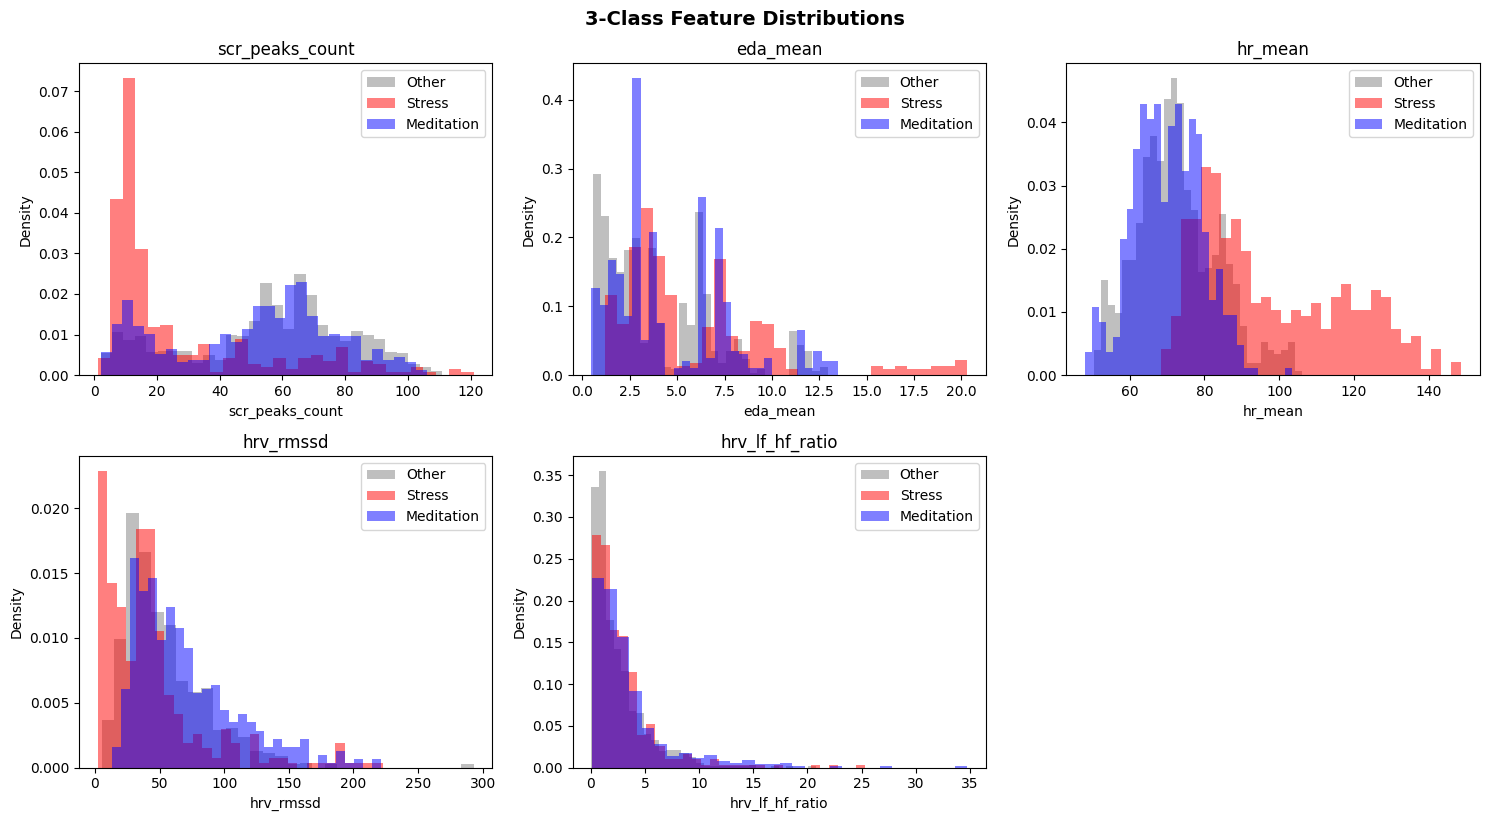


Feature Statistics by Class:
            scr_peaks_count  eda_mean  hr_mean  hrv_rmssd  hrv_lf_hf_ratio
class_name                                                                
Meditation            50.92      4.62    70.24      71.00             3.54
Other                 55.98      4.06    72.79      53.86             2.46
Stress                25.83      5.91    97.88      43.50             2.89


In [10]:
# Plot distributions of key features by Class (Stress vs Meditation vs Other)

# Temporary mapping for visualization
def map_viz_label(l):
    if l == 2: return 'Stress'
    if l == 4: return 'Meditation'
    if l in [1, 3]: return 'Other'
    return None

viz_df = features_df.copy()
viz_df['class_name'] = viz_df['label'].apply(map_viz_label)
viz_df = viz_df.dropna(subset=['class_name'])

# Select key features to visualize
key_features = ['scr_peaks_count', 'eda_mean', 'hr_mean', 'hrv_rmssd', 'hrv_lf_hf_ratio']

fig, axes = plt.subplots(2, 3, figsize=(15, 8))
axes = axes.flatten()

classes = ['Other', 'Stress', 'Meditation']
colors = {'Other': 'gray', 'Stress': 'red', 'Meditation': 'blue'}

for i, feature in enumerate(key_features):
    ax = axes[i]
    
    for cls in classes:
        subset = viz_df[viz_df['class_name'] == cls][feature].dropna()
        ax.hist(subset, bins=30, alpha=0.5, label=cls, density=True, color=colors[cls])
    
    ax.set_xlabel(feature)
    ax.set_ylabel('Density')
    ax.legend()
    ax.set_title(f'{feature}')

# Remove extra subplot
fig.delaxes(axes[5])

plt.tight_layout()
plt.suptitle('3-Class Feature Distributions', y=1.02, fontsize=14, fontweight='bold')
plt.show()

# Print statistics
print('\nFeature Statistics by Class:')
print(viz_df.groupby('class_name')[key_features].mean().round(2))

## 4. Training

Multi-Class Classification (Stress vs Meditation vs Other)

Implemented a 3-class Linear SVM with subject-wise validation to prevent data leakage.

In [11]:
# 1. Define Constants & Configuration
TEST_SIZE = 0.2
RANDOM_STATE = 42
SVM_C = 1.0
MAX_ITER = 20000
LABEL_ORDER = ['stress', 'meditation', 'other']

print('Configuration:')
print(f'  Test Size (Subjects): {TEST_SIZE}')
print(f'  SVM C: {SVM_C}')
print(f'  Random State: {RANDOM_STATE}')

Configuration:
  Test Size (Subjects): 0.2
  SVM C: 1.0
  Random State: 42


In [12]:
# 2. Prepare 3-Class Dataset
import numpy as np
import pandas as pd

# Map original labels to 3 classes
# Original: 1=Baseline, 2=Stress, 3=Amusement, 4=Meditation
def map_3class(label):
    if label == 2:
        return 'stress'
    elif label == 4:
        return 'meditation'
    elif label in [1, 3]:
        return 'other'
    return None

df = features_df.copy()
df['y3'] = df['label'].apply(map_3class)

# Drop rows with missing/undefined labels
df_clean = df.dropna(subset=['y3']).copy()

# Define features (exclude metadata)
meta_cols = ['label', 'y3', 'subject']
feature_cols = [c for c in df_clean.columns if c not in meta_cols]

# Define X, y, groups
X = df_clean[feature_cols].values
y = df_clean['y3'].values
groups = df_clean['subject'].values

# Assertions
assert not np.isnan(X).any(), "X contains NaNs!"

print('Dataset Prepared:')
print(f'  Total Samples: {len(df_clean)}')
print(f'  Feature Count: {len(feature_cols)}')
print(f'  Subject Count: {len(np.unique(groups))}')
print('\nClass Counts:')
print(df_clean['y3'].value_counts())

print('\nCounts per Subject:')
print(df_clean.groupby(['subject', 'y3']).size().unstack(fill_value=0))

Dataset Prepared:
  Total Samples: 1643
  Feature Count: 28
  Subject Count: 15

Class Counts:
y3
other         827
meditation    454
stress        362
Name: count, dtype: int64

Counts per Subject:
y3       meditation  other  stress
subject                           
S10              32     55      26
S11              30     57      25
S13              31     57      24
S14              31     55      24
S15              30     55      25
S16              30     55      24
S17              29     55      26
S2               29     54      23
S3               30     55      24
S4               31     54      23
S5               30     55      23
S6               30     55      24
S7               30     55      23
S8               30     55      25
S9               31     55      23


In [13]:
# 3. Subject-Wise Split (No Leakage)
from sklearn.model_selection import GroupShuffleSplit

# Split DataFrames to preserve metadata ('label', 'subject') for normalization
gss = GroupShuffleSplit(n_splits=1, test_size=TEST_SIZE, random_state=RANDOM_STATE)
train_idx, test_idx = next(gss.split(df_clean, df_clean['y3'], df_clean['subject']))

df_train = df_clean.iloc[train_idx].copy()
df_test = df_clean.iloc[test_idx].copy()

y_train = df_train['y3'].values
y_test = df_test['y3'].values

print('Subject Split:')
print(f"  Train Subjects: {df_train['subject'].unique()}")
print(f"  Test Subjects:  {df_test['subject'].unique()}")
print(f"\n  Train Samples: {len(df_train)}")
print(f"  Test Samples:  {len(df_test)}")

train_subs = df_train['subject'].unique()
test_subs = df_test['subject'].unique()


Subject Split:
  Train Subjects: ['S11' 'S13' 'S14' 'S15' 'S16' 'S17' 'S2' 'S3' 'S5' 'S7' 'S8' 'S9']
  Test Subjects:  ['S10' 'S4' 'S6']

  Train Samples: 1313
  Test Samples:  330


In [14]:
# 3b. Normalize Features (Baseline-Only Per-Subject)
print("Normalizing features using subject-specific baselines...")

# Define baseline label (1 = Baseline)
# Note: df_clean/df_train has 'label' (original 1,2,3,4) and 'y3' (mapped). 
# normalize_subjects uses 'label' column to find baseline=1.
BASELINE_LABEL_IN_ORIGINAL = 1 

X_train_norm, X_test_norm = normalize_subjects(
    df_train, 
    df_test, 
    feature_cols, 
    label_col='label', 
    baseline_label=BASELINE_LABEL_IN_ORIGINAL, 
    subject_col='subject'
)

print(f"X_train_norm: {X_train_norm.shape}")
print(f"X_test_norm: {X_test_norm.shape}")


Normalizing features using subject-specific baselines...
X_train_norm: (1313, 28)
X_test_norm: (330, 28)


In [15]:
# 4. Train Linear SVM Pipeline
from sklearn.svm import LinearSVC
from sklearn.pipeline import Pipeline

# Note: StandardScaler is REMOVED because we performed baseline normalization.

pipe = Pipeline([
    # ('scaler', StandardScaler()), 
    ('svm', LinearSVC(class_weight='balanced', C=SVM_C, max_iter=MAX_ITER, random_state=RANDOM_STATE))
])

print('Training Pipeline with Baseline-Normalized Features...')
pipe.fit(X_train_norm, y_train)
print('✓ Model Trained.')


Training Pipeline with Baseline-Normalized Features...
✓ Model Trained.


Test Accuracy: 80.00%

Classification Report:
              precision    recall  f1-score   support

      stress       0.87      0.85      0.86        73
  meditation       0.70      0.61      0.65        93
       other       0.82      0.88      0.85       164

    accuracy                           0.80       330
   macro avg       0.80      0.78      0.79       330
weighted avg       0.80      0.80      0.80       330

Recall (stress): 84.9%
Recall (meditation): 61.3%
Recall (other): 88.4%


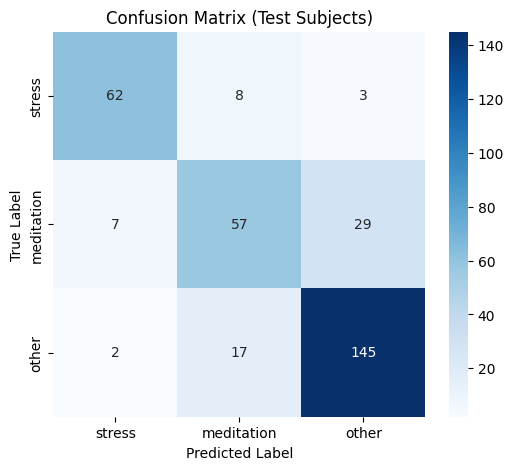

In [16]:
# 5. Evaluate Performance
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

y_pred = pipe.predict(X_test_norm)

acc = accuracy_score(y_test, y_pred)
print(f'Test Accuracy: {acc*100:.2f}%\n')

print('Classification Report:')
print(classification_report(y_test, y_pred, labels=LABEL_ORDER))

# Per-class recall
cm = confusion_matrix(y_test, y_pred, labels=LABEL_ORDER)
class_recall = cm.diagonal() / cm.sum(axis=1)
for i, label in enumerate(LABEL_ORDER):
    print(f'Recall ({label}): {class_recall[i]*100:.1f}%')

# Plot Confusion Matrix
plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
            xticklabels=LABEL_ORDER, yticklabels=LABEL_ORDER)
plt.title('Confusion Matrix (Test Subjects)')
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.show()


In [17]:
# 7. Save Model & Metadata
import joblib
import datetime

models_dir = Path('../models')
models_dir.mkdir(exist_ok=True)
model_path = models_dir / 'wesad_linear_svm_3class.joblib'

artifact = {
    'pipeline': pipe,
    'feature_cols': feature_cols,
    'label_order': LABEL_ORDER,
    'train_subjects': train_subs,
    'test_subjects': test_subs,
    'hyperparameters': {'C': SVM_C, 'class_weight': 'balanced'},
    'timestamp': datetime.datetime.now().isoformat()
}

joblib.dump(artifact, model_path)
print(f'Model saved to: {model_path}')

Model saved to: ../models/wesad_linear_svm_3class.joblib


In [18]:
# 8. Inference Function
def predict_state_from_features(data_row):
    """
    Predict state (stress/meditation/other) from a feature dictionary or row.
    Args:
        data_row (dict or pd.Series): Must contain all training feature columns.
    Returns:
        str: Predicted label
    """
    # Convert to DataFrame to match feature names if possible, or straight to array
    if isinstance(data_row, dict):
        df_in = pd.DataFrame([data_row])
    else:
        df_in = pd.DataFrame([data_row])
        
    # Ensure columns match
    try:
        X_in = df_in[feature_cols].values
    except KeyError as e:
        raise ValueError(f"Missing features: {e}")
        
    pred = pipe.predict(X_in)[0]
    return pred

# Quick Test
sample_row = df_clean.iloc[0][feature_cols]
print(f'Inference Test:\n  Input Label: {df_clean.iloc[0]["y3"]}\n  Prediction:  {predict_state_from_features(sample_row)}')

Inference Test:
  Input Label: other
  Prediction:  stress


In [ ]:
# 9. Summary
print('='*60)
print('PIPELINE COMPLETE')
print('='*60)
print(f'Saved Model Size: {model_path.stat().st_size / 1024:.2f} KB')
print(f'Features used: {len(feature_cols)}')
print(f'Train Samples: {len(X_train_norm)} (Subjects: {len(train_subs)})')
print(f'Test Samples:  {len(X_test_norm)}  (Subjects: {len(test_subs)})')

PIPELINE COMPLETE
Saved Model Size: 2.66 KB
Features used: 28
Train Samples: 1313 (Subjects: 12)
Test Samples:  330  (Subjects: 3)
